In [1]:
import numpy as np
import warnings
import copy
import os
import pandas as pd
warnings.filterwarnings("ignore")
import sys
sys.path.append('../induction_motor_anomaly_detection/')
import modules,scaler

In [2]:
normal_data = pd.read_csv('../data/combined_data.csv')
anomalous_data = pd.read_csv('../anomalous_data/a_data2.csv')


In [ ]:
# train_data_features = modules.ElectricalFeatureExtractor(current_data=normal_data)
# test_data_features = modules.ElectricalFeatureExtractor(current_data=anomalous_data)
# train_scaler = scaler.Scaler()
# train_scaler.fit_unlabelled_data(train_data_features.feature_dataframe[0])
# train_scaled = train_scaler.transform(train_data_features.feature_dataframe[0])
# test_scaled = train_scaler.transform(test_data_features.feature_dataframe[0])

In [3]:
train_scaler = scaler.Scaler()
train_scaler.fit_unlabelled_data(normal_data)


using MinMaxScaler()


In [4]:
train_scaled = train_scaler.transform(normal_data)
anomalous_scaled = train_scaler.transform(anomalous_data)


In [5]:
import matplotlib.pyplot as plt

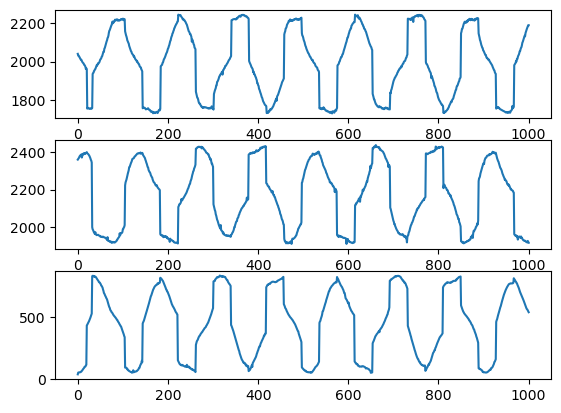

In [6]:
plt.subplot(3, 1, 1)
plt.plot(normal_data['current_1'].loc[0:1000])
plt.subplot(3, 1, 2)
plt.plot(normal_data['current_2'].loc[0:1000])
plt.subplot(3, 1, 3)
plt.plot(normal_data['current_3'].loc[0:1000])

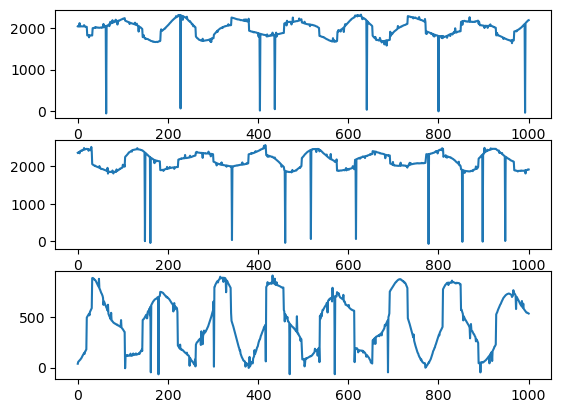

In [7]:
plt.subplot(3, 1, 1)
plt.plot(anomalous_data['current_1'].loc[0:1000])
plt.subplot(3, 1, 2)
plt.plot(anomalous_data['current_2'].loc[0:1000])
plt.subplot(3, 1, 3)
plt.plot(anomalous_data['current_3'].loc[0:1000])

In [9]:
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [10]:

# model subclassing
class AutoEncoder(Model):
  def __init__(self,activation='relu'):
# In this code, AutoEncoder is a subclass of the Model class from the TensorFlow Keras API. When defining a subclass of a Python class, it is necessary to call the constructor of the parent class in order to initialize any inherited attributes or methods.
# The super() function is used to call the constructor of the parent class. In this case, it calls the constructor of the Model class to initialize the AutoEncoder object as a Keras model.
# Even though Model is not explicitly defined in the code, it is inherited by the AutoEncoder class, as it is defined in the TensorFlow Keras API. By calling super(AutoEncoder, self).__init__(), the constructor of the parent class (Model) is called, which initializes the necessary attributes for AutoEncoder to function as a Keras model.
    super(AutoEncoder, self).__init__()  #not required but ensures that the AutoEncoder class is properly initialized as a Keras model, and it is compatible with other Keras models and tools.   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(8, activation=activation)])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation=activation),
      tf.keras.layers.Dense(32, activation=activation),
      tf.keras.layers.Dense(64, activation=activation),
      tf.keras.layers.Dense(3, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)  #compresses the data
    decoded = self.decoder(encoded) #reconstructs the original data 
    return decoded
  



In [11]:
model= AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',     #stop if val_loss does not improve for more than 2 epochs
                                                    patience=2,
                                                    mode='min')  #check for min of val_loss, if accuracy then it should be max, 'auto' does it automatically

model.compile(optimizer='adam', loss='mae')  



In [ ]:
# file = 0
# for i in range(0,len(train_scaled), 10000):
#   history = model.fit(train_scaled[0:1000], train_scaled[0:1000], #passing something as y, preferrably the same data, since this is an unsupervised algo.
#             epochs=50, 
#             batch_size=128,
#             validation_data=(train_scaled[0:1000], train_scaled[0:1000]), #passing combined data, to make model train harder, as per author.
#             shuffle=True,
#           #  We can and probably should use normal data only, for val, since we are fitting the model to be compress and decompress normal data, as well as detect abnormal data if reconstruction error is high
#             callbacks=[early_stopping], verbose = 0)

from tqdm import tqdm

file = 0
for i in tqdm(range(0, len(train_scaled), 10000)):
    history = model.fit(train_scaled[i:i+10000], train_scaled[i:i+10000],
                        epochs=50,
                        batch_size=128,
                        validation_data=(train_scaled[i:i+10000], train_scaled[i:i+10000]),
                        shuffle=True,
                        callbacks=[early_stopping],
                        verbose=0)

In [15]:
encoder_out = model.encoder(train_scaled).numpy()
decoder_out = model.decoder(encoder_out).numpy()

In [16]:
encoder_out.shape,decoder_out.shape

((3170000, 8), (3170000, 3))

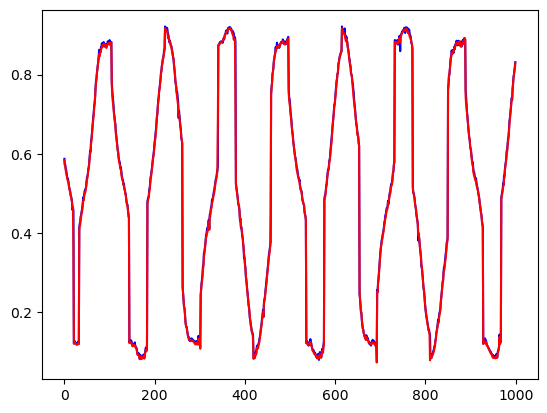

In [17]:
plt.plot(train_scaled[0:1000,0:1],'b')
plt.plot(decoder_out[0:1000,0:1],'r')

In [19]:
encoder_out_a = model.encoder(anomalous_scaled).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

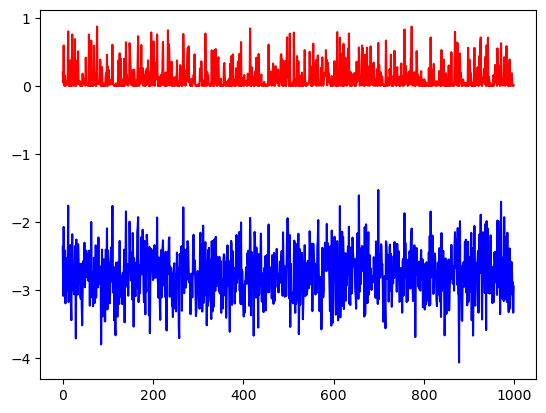

In [20]:
plt.plot(anomalous_scaled[0:1000,0:1],'b')
plt.plot(decoder_out_a[0:1000,0:1],'r')

In [21]:
tf.keras.losses.mae(decoder_out[0], train_scaled[0])


<tf.Tensor: shape=(), dtype=float64, numpy=0.007531214185362474>

In [22]:
tf.keras.losses.mae(decoder_out_a[0], anomalous_scaled[0])

<tf.Tensor: shape=(), dtype=float64, numpy=2.129822944497502>

In [23]:
reconstructions = model.predict(train_scaled)
train_loss = tf.keras.losses.mae(reconstructions, train_scaled)

# do plotting seperately as it takes a lot of time to plot the whole dataset
# plt.hist(train_loss, bins=50)

99063/99063 [==============================] - 224s 2ms/step


<AxesSubplot:ylabel='Density'>

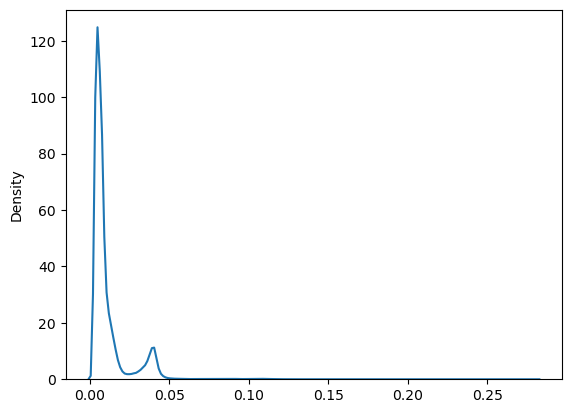

In [67]:
import seaborn as sns
sns.kdeplot(train_loss, bw_adjust= 0.5)
# If plt.hist(train_loss, bins=50) takes too long to plot, you can try using a kernel density estimate (KDE) plot instead. This can be created using the seaborn library, which is built on top of matplotlib

In [ ]:
# plt.hist(train_loss, bins=20) # or reduce bins, but still takes too long

In [57]:
threshold = np.mean(train_loss) + 3*np.std(train_loss)

In [58]:
threshold

0.048997336904361165

In [59]:
np.sum(train_loss > threshold)

30956

In [61]:
indices = np.where(tf.math.less(train_loss, threshold) == False)[0]

In [63]:
import numpy as np

# Assuming each file has 1000 data points
file_size = 10000
num_files = len(train_scaled) // file_size

# Create histogram of indices based on file number
hist, bin_edges = np.histogram(indices, bins=num_files, range=(0, len(train_scaled)))
file_indices = np.digitize(indices, bin_edges[:-1])

# Count number of anomalies per file
file_counts = {}
for i in range(1, num_files+1):
    file_counts[i] = np.count_nonzero(file_indices == i)

# Sort files by number of anomalies (in descending order)
sorted_files = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

# Print results
for file_num, count in sorted_files:
    print(f"File {file_num}: {count} anomalies")


File 236: 1814 anomalies
File 240: 936 anomalies
File 231: 766 anomalies
File 229: 267 anomalies
File 233: 185 anomalies
File 232: 151 anomalies
File 224: 125 anomalies
File 206: 119 anomalies
File 213: 117 anomalies
File 210: 116 anomalies
File 208: 115 anomalies
File 202: 114 anomalies
File 230: 113 anomalies
File 215: 112 anomalies
File 217: 112 anomalies
File 199: 110 anomalies
File 209: 109 anomalies
File 212: 109 anomalies
File 198: 106 anomalies
File 214: 106 anomalies
File 207: 105 anomalies
File 216: 105 anomalies
File 225: 104 anomalies
File 161: 103 anomalies
File 242: 102 anomalies
File 243: 102 anomalies
File 154: 101 anomalies
File 205: 101 anomalies
File 121: 100 anomalies
File 266: 100 anomalies
File 23: 99 anomalies
File 29: 99 anomalies
File 220: 99 anomalies
File 151: 98 anomalies
File 184: 98 anomalies
File 185: 98 anomalies
File 218: 98 anomalies
File 221: 98 anomalies
File 260: 98 anomalies
File 241: 97 anomalies
File 245: 97 anomalies
File 287: 97 anomalies
File 

In [68]:
reconstructions_a = model.predict(anomalous_scaled)
train_loss_a = tf.keras.losses.mae(reconstructions_a, anomalous_scaled)

# plt.hist(train_loss_a, bins=50)

32/32 [==============================] - 0s 3ms/step


In [70]:
len(train_loss_a)

1000

In [72]:
np.sum(train_loss_a > threshold)

1000

In [ ]:
# plt.hist(train_loss, bins=50, label='normal')
# plt.hist(train_loss_a, bins=50, label='anomaly')
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
# plt.legend(loc='upper right')
# plt.show()
# The distplot function will automatically plot the histogram and the kernel density estimation curve. The hist_kws argument is used to customize the histogram appearance, such as the edge color. The axvline function from Matplotlib can still be used to add a vertical line at the threshold value. The legend function is used to add a legend with custom labels for each histogram. Finally, show function is used to display the plot.

sns.distplot(train_loss, bins=50, kde=True, hist_kws={'edgecolor':'black'})
sns.distplot(train_loss_a, bins=50, kde=True, hist_kws={'edgecolor':'black'})
sns.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
sns.legend(labels=['normal', 'anomaly', 'threshold'])
sns.show()


For real Real time : generator function that reads and yields batches of data from the files as they come

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, file_paths, batch_size):
    self.file_paths = file_paths
    self.batch_size = batch_size

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    file_path = self.file_paths[idx]
    data = load_data(file_path) # implement this function to load data from file
    batch_idx = 0
    while (batch_idx + 1) * self.batch_size <= len(data):
      batch = data[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
      batch_idx += 1
      yield batch, batch # return the batch as both x and y, since this is an unsupervised learning task

# Define the file paths
file_paths = [...] # list of file paths

# Initialize the data generator
batch_size = 128
data_generator = DataGenerator(file_paths, batch_size)

# Initialize the model
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
model.compile(optimizer='adam', loss='mae')

# Train the model
for epoch in range(50):
  print(f'Epoch {epoch+1}/{50}')
  for i, (x, y) in enumerate(data_generator):
    loss = model.train_on_batch(x, y)
    print(f'Batch {i+1}/{len(data_generator)} - Loss: {loss:.4f}')


`DataGenerator` class inherits from `tf.keras.utils.Sequence` and implements the `__len__` and `__getitem__` methods. The `__len__` method returns the number of files in the `file_paths list`, and the `__getitem__` method reads and yields batches of data from each file. The `train_on_batch` method is used to train the model on each batch of data, and the progress is printed to the console. The outer loop iterates over epochs, and the inner loop iterates over files using the `DataGenerator`.